In [114]:
#Importation des libraires
import urllib.request
import sys
import tarfile
import os
import numpy
import sklearn
import email
import email.policy
import numpy as np
import re
from html import unescape
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
import collections
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import tree
import matplotlib.pyplot as plt


# **Importing/Loading data**

In [115]:
#Focntion pour telecharger la base d'apprentissage et l'extraire
def download_data(fns, urls, p, type):

    for (filename, url) in zip(fns, urls):
        path = os.path.join(p, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        
        # remove the path by reset it
        members = []
        for member in tar_bz2_file.getmembers():
            if member.isreg():
                member.name = os.path.basename(member.name) 
                members.append(member)
        tar_bz2_file.extractall(path=p+type, members=members)
        tar_bz2_file.close()
    

In [116]:
#Liens de telechargement Spam/Non Spam(Ham)

DOWNLOAD_ROOT = "https://spamassassin.apache.org/old/publiccorpus/"

HAM1_URL = DOWNLOAD_ROOT + "20021010_easy_ham.tar.bz2"

HAM3_URL = DOWNLOAD_ROOT + "20030228_easy_ham_2.tar.bz2"

HAM5_URL = DOWNLOAD_ROOT + "20030228_hard_ham.tar.bz2"

HAM_URL = [HAM1_URL, HAM3_URL,HAM5_URL]

HAM_FILENAME = ["ham1.tar.bz2",  "ham3.tar.bz2","ham5.tar.bz2",]


SPAM1_URL = DOWNLOAD_ROOT + "20021010_spam.tar.bz2 "

SPAM4_URL = DOWNLOAD_ROOT + "20050311_spam_2.tar.bz2"

SPAM_URL = [SPAM1_URL,SPAM4_URL]

SPAM_FILENAME = ["spam1.tar.bz2", "spam4.tar.bz2"]

PATH = "./data/"

if not os.path.isdir(PATH):
  os.makedirs(PATH)
  
download_data(SPAM_FILENAME, SPAM_URL, PATH, "spam")

download_data(HAM_FILENAME, HAM_URL, PATH, "ham")

In [117]:
def load_emails(directory, filename):
    
    with open(os.path.join(directory, filename), "rb") as f:
      
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [118]:
ham_filenames = [name for name in sorted(os.listdir("./data/ham")) if name != 'cmds']
spam_filenames = [name for name in sorted(os.listdir("./data/spam")) if name != 'cmds']

ham_emails = [load_emails("./data/ham", filename=name) for name in ham_filenames]
spam_emails = [load_emails("./data/spam", filename=name) for name in spam_filenames]

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))



In [119]:
X.shape, y.shape


((6098,), (6098,))

# **Data Visualisation**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show>

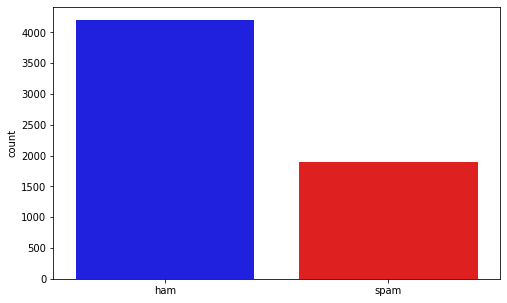

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
ham = np.array(ham_emails)
spam = np.array(spam_emails)

colors =['blue','red']

plt.figure(figsize=(8, 5))
sns.countplot(x = ['ham']*len(ham) + ['spam']*len(spam), palette=colors)
plt.show

# **Pre processing**

Les emails importes ne sont pas lisibles directement, il faut donc une fonction qui permet leur lecture

In [164]:
#print(X.tostring())

In [122]:
#Convertir HTML en texte lisible
def html_to_text(html):

    text = re.sub(r'<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub(r'<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub(r'<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    
    return unescape(text) 


In [123]:
#Convertir les emails en texte lisible
def message_to_text(email):
    
    html = None
    for entity in email.walk():

        #Quelques emails ont plusieurs parties, chaque partie est traitee separemmenet 
        entity_type = entity.get_content_type()
        if not entity_type in ("text/plain", "text/html"):
            continue
        
        try:
            content = entity.get_content()
            
        except: #Parfois ceci est impossible pour des raisons d'encodage
            content = str(entity.get_payload())
        if entity_type == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_text(html)

**Minuscule**

In [124]:
def minuscule(texte):
  
  return(texte.lower())

**Suppression de balises HTML**

In [125]:
def replace_html(texte):
  
  return re.sub('<[^<>]+>', ' ', texte)

**Normalisation des URL**

In [126]:
def replace_urls(texte):
      
    return re.sub('(http|https)://[^\s]*', 'httpaddr', texte)

**Normalisation des adresses e-mail**

In [127]:
def replace_emails(texte):
    
    return re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', "emailaddr", texte)

**Normalisation des nombres**

In [128]:
def replace_numbers(texte):
   
    return re.sub(r'[0-9]+', 'nombre', texte)

**Normalisation des dollars**

In [129]:
def replace_dollars(texte):
    
    return re.sub(r"\$", 'dollar', texte)

**Radicalisation de mots - word stemming**

In [130]:
def radicalisation(texte):

  new_text =[]  

  #Separer les phrases en mots
  texte = texte.split()

  #Appliquer snowball stemmer sur chaque mot
  for e in texte:
        #Suppression de tout charactere non alphanumerique
        e = re.sub('[^a-zA-Z0-9]', '', e)
        
        #Creation du stemmer
        stemmer = SnowballStemmer("english")
        
        #Radicalisation du mot
        e = stemmer.stem(e.strip())

        #Ne pas prendre en consideration les mots de longeur 1
        if len(e) < 1:
           continue

        new_text.append(e)

  final_text = " ".join(new_text)


  return final_text
 

In [131]:
texte = "discount, discounts, discounted et discounting devront être tous remplacé par  discount, et include includes, included, et ncluded devront être tous remplacés par « includ »."
rad = radicalisation(texte)
print(rad)

discount discount discount et discount devront tre tous remplac par discount et includ includ includ et nclude devront tre tous remplac par includ


**Suppression des non-mots**

In [132]:
def remove_non_mots(texte):
  for x in texte:
    if x in punctuation:
        texte = texte.replace(x, " ")

  texte = re.sub(r"\n", ' ', texte)
  texte = re.sub(r"\t", ' ', texte)
  texte = re.sub(r"\s", ' ', texte)
  texte =re.sub("[ ]{2,}", " ", texte)
    
  return texte 

In [133]:
def Preprocess(X): 
  i=0 
  X_Preprocess =[]
  for texte in X:
    #print(i)
    
    texte = message_to_text(texte) or ""
    texte = minuscule(texte)
    texte = replace_numbers(texte)
    texte = replace_dollars(texte)
    texte = replace_urls(texte)
    texte = replace_emails(texte)
    texte = replace_html(texte)
    texte = remove_non_mots(texte)
    texte = radicalisation(texte)
    X_Preprocess.append(texte)
    #i=i+1
  return X_Preprocess
        


*Test de toutes les fonctions*

In [134]:
str1 = 'Anyone $$$$$ knows how much $ it costs to host a web portal ? Well, it depends on how many visitors youre expecting. This can be anywhere from less than 10 bucks a month to a couple of $100. You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if youre running something big.. To unsubscribe yourself from this mailing list, send an email to: groupname-unsubscribe@egroups.com'

print("\nAvant le preprocessing :\n",str1)
str1 = minuscule(str1)
str1 = replace_numbers(str1)
str1 = replace_dollars(str1)

str1 = replace_urls(str1)
str1= replace_emails(str1)
str1 = replace_html(str1)
str1 = remove_non_mots(str1)
str1=radicalisation(str1)

print("\nApres le preprocessing :\n",str1)



Avant le preprocessing :
 Anyone $$$$$ knows how much $ it costs to host a web portal ? Well, it depends on how many visitors youre expecting. This can be anywhere from less than 10 bucks a month to a couple of $100. You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if youre running something big.. To unsubscribe yourself from this mailing list, send an email to: groupname-unsubscribe@egroups.com

Apres le preprocessing :
 anyon dollardollardollardollardollar know how much dollar it cost to host a web portal well it depend on how mani visitor your expect this can be anywher from less than nombr buck a month to a coupl of dollarnombr you should checkout httpaddr or perhap amazon ecnombr if your run someth big to unsubscrib yourself from this mail list send an email to emailaddr


# **Feature extraction**

In [135]:
X_features = Preprocess(X)

In [136]:
X_features[0]

'date tue nombr aug nombr nombr nombr nombr nombr from chris garrigu messag id i m hope that all peopl with no addit sequenc will notic are pure cosmet chang well first when exmh the latest one with your chang start i get can t read flist totalcount unseen no such element in array while execut if dollarflist totalcount dollarmhprofil unseen sequenc nombr flaginn spool iconspool labelup els flaginn down icondown labeldown procedur flag msgseen line nombr invok from within flag msgseen procedur msgseen line nombr invok from within msgseen dollarmsgid procedur msgshow line nombr invok from within msgshow dollarmsgid procedur msgchang line nombr invok from within msgchang nombr show invok from within time list msgchang dollarmsgid dollarshow procedur msg chang line nombr invok from within msg chang dollarmsg id dollarshow procedur msg show line nombr invok from within msg show cur eval bodi line nombr invok from within eval dollarmsgshowproc procedur folderchang line nombr invok from withi

In [137]:
vocab = X_features
vocab = ''.join(vocab)

In [138]:
#Creation of vocabList
def vocablist(X):

  l = X.split()
  word_counts = collections.Counter(l)

  return word_counts

In [139]:
f = vocablist(vocab)
#Nous allons tester plusieurs k, k etant le nombre de mots dans notre vocabulaire
number_k = [1000, 1500, 2000, 2500]
for k in number_k:
  common_element = f.most_common(k)



In [140]:
'''f = open("WORS_OCCURENCES.txt", "w")
for w, count in mostcom:
    
    f.write(w)
    f.write("->")
    f.write(str(count))
    f.write('\n')'''




'f = open("WORS_OCCURENCES.txt", "w")\nfor w, count in mostcom:\n    \n    f.write(w)\n    f.write("->")\n    f.write(str(count))\n    f.write(\'\n\')'

# **Create a feature vector to get the vocabulary list as it has a better time complexity**

In [141]:
def countVect(k):
  count_vect = CountVectorizer(max_features=k,binary=True)
  count_vect.fit(X_features)
  x = count_vect.transform(X_features).toarray()
  
  return x

In [142]:
x_1000 = countVect(1000)
x_1500 = countVect(1500)
x_2000 = countVect(2000)
x_2500 = countVect(2500)

In [143]:
x_1500.shape, x_2000.shape, x_2500.shape

((6098, 1500), (6098, 2000), (6098, 2500))

In [144]:
X_train_1000, X_test_1000, y_train_1000, y_test_1000 = train_test_split(x_1000, y, random_state=0, train_size = .75)
X_train_1500, X_test_1500, y_train_1500, y_test_1500 = train_test_split(x_1500, y, random_state=0, train_size = .75)
X_train_2000, X_test_2000, y_train_2000, y_test_2000 = train_test_split(x_2000, y, random_state=0, train_size = .75)
X_train_2500, X_test_2500, y_train_2500, y_test_2500 = train_test_split(x_2500, y, random_state=0, train_size = .75)


# **Model training**

# **SVM**

In [145]:
def metriques(y_test, y_pred, name):

  print("Le classifieurs : ", name)
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Precision:",metrics.precision_score(y_test, y_pred))
  print("Recall:",metrics.recall_score(y_test, y_pred))
  print("F1-score: ",metrics.f1_score(y_test, y_pred) )
  print(confusion_matrix(y_test, y_pred))
  

In [146]:
def SVM(X_train, y_train, X_test, y_test):

  svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  svm.fit(X_train, y_train)
  Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(gamma='auto'))])
  y_pred = svm.predict(X_test)
  metriques(y_test, y_pred, "SVM")
  return y_pred

In [147]:
print("\nPour k = 1000\n")
SVM(X_train_1000, y_train_1000, X_test_1000, y_test_1000)
print("\nPour k = 1500\n")
SVM(X_train_1500, y_train_1500, X_test_1500, y_test_1500)
print("\nPour k = 2000\n")
ypred_svm =SVM(X_train_2000, y_train_2000, X_test_2000, y_test_2000)

print("\nPour k = 2500\n")
SVM(X_train_2500, y_train_2500, X_test_2500, y_test_2500)


Pour k = 1000

Le classifieurs :  SVM
Accuracy: 0.9737704918032787
Precision: 0.9862068965517241
Recall: 0.9265658747300216
F1-score:  0.955456570155902
[[1056    6]
 [  34  429]]

Pour k = 1500

Le classifieurs :  SVM
Accuracy: 0.9711475409836066
Precision: 0.9860788863109049
Recall: 0.91792656587473
F1-score:  0.9507829977628635
[[1056    6]
 [  38  425]]

Pour k = 2000

Le classifieurs :  SVM
Accuracy: 0.9704918032786886
Precision: 0.9837962962962963
Recall: 0.91792656587473
F1-score:  0.9497206703910615
[[1055    7]
 [  38  425]]

Pour k = 2500

Le classifieurs :  SVM
Accuracy: 0.9685245901639344
Precision: 0.9859484777517564
Recall: 0.9092872570194385
F1-score:  0.946067415730337
[[1056    6]
 [  42  421]]


array([0, 1, 1, ..., 1, 0, 0])

# **Gaussian Native Bayes**

In [148]:
def Gaussian(X_train, y_train, X_test, y_test):

  gnb = GaussianNB()
  y_pred2 = gnb.fit(X_train, y_train).predict(X_test)
  metriques(y_test, y_pred2, "Gaussian")
  return y_pred2

In [149]:
print("\nPour k = 1000\n")
Gaussian(X_train_1000, y_train_1000, X_test_1000, y_test_1000)
print("\nPour k = 1500\n")
Gaussian(X_train_1500, y_train_1500, X_test_1500, y_test_1500)
print("\nPour k = 2000\n")
y_pred_gauss=Gaussian(X_train_2000, y_train_2000, X_test_2000, y_test_2000)
print("\nPour k = 2500\n")
Gaussian(X_train_2500, y_train_2500, X_test_2500, y_test_2500)


Pour k = 1000

Le classifieurs :  Gaussian
Accuracy: 0.8747540983606558
Precision: 0.7172523961661342
Recall: 0.9697624190064795
F1-score:  0.8246097337006428
[[885 177]
 [ 14 449]]

Pour k = 1500

Le classifieurs :  Gaussian
Accuracy: 0.8262295081967214
Precision: 0.6451612903225806
Recall: 0.9503239740820735
F1-score:  0.7685589519650655
[[820 242]
 [ 23 440]]

Pour k = 2000

Le classifieurs :  Gaussian
Accuracy: 0.8380327868852459
Precision: 0.6636363636363637
Recall: 0.9460043196544277
F1-score:  0.7800534283170081
[[840 222]
 [ 25 438]]

Pour k = 2500

Le classifieurs :  Gaussian
Accuracy: 0.8321311475409836
Precision: 0.6561085972850679
Recall: 0.9395248380129589
F1-score:  0.7726465364120781
[[834 228]
 [ 28 435]]


array([0, 1, 1, ..., 1, 0, 0])

# **Naive Bayes classifier for multinomial models. (discrete)** 

In [150]:
def Bayes(X_train, y_train, X_test, y_test):
  gnb = MultinomialNB()
  y_predMNB = gnb.fit(X_train, y_train).predict(X_test)
  metriques(y_test, y_predMNB, "Multinomnial Naive Bayes" )
  return y_predMNB

In [151]:
print("\nPour k = 1000\n")
Bayes(X_train_1000, y_train_1000, X_test_1000, y_test_1000)
print("\nPour k = 1500\n")
Bayes(X_train_1500, y_train_1500, X_test_1500, y_test_1500)
print("\nPour k = 2000\n")
y_pred_MNB=Bayes(X_train_2000, y_train_2000, X_test_2000, y_test_2000)

print("\nPour k = 2500\n")
Bayes(X_train_2500, y_train_2500, X_test_2500, y_test_2500)


Pour k = 1000

Le classifieurs :  Multinomnial Naive Bayes
Accuracy: 0.9685245901639344
Precision: 0.9501084598698482
Recall: 0.9460043196544277
F1-score:  0.948051948051948
[[1039   23]
 [  25  438]]

Pour k = 1500

Le classifieurs :  Multinomnial Naive Bayes
Accuracy: 0.9718032786885246
Precision: 0.9565217391304348
Recall: 0.9503239740820735
F1-score:  0.9534127843986999
[[1042   20]
 [  23  440]]

Pour k = 2000

Le classifieurs :  Multinomnial Naive Bayes
Accuracy: 0.9711475409836066
Precision: 0.9544468546637744
Recall: 0.9503239740820735
F1-score:  0.9523809523809523
[[1041   21]
 [  23  440]]

Pour k = 2500

Le classifieurs :  Multinomnial Naive Bayes
Accuracy: 0.9711475409836066
Precision: 0.9544468546637744
Recall: 0.9503239740820735
F1-score:  0.9523809523809523
[[1041   21]
 [  23  440]]


array([0, 1, 1, ..., 1, 0, 0])

# **Logistic regression**

In [152]:
def Log_Reg(X_train, y_train, X_test, y_test):
  lr = LogisticRegression(random_state=0).fit(X_train, y_train)
  y_pred3=lr.predict(X_test)
  metriques(y_test, y_pred3, "Logistic Regression")
  return y_pred3

In [153]:
print("\nPour k = 1000\n")
Log_Reg(X_train_1000, y_train_1000, X_test_1000, y_test_1000)
print("\nPour k = 1500\n")
Log_Reg(X_train_1500, y_train_1500, X_test_1500, y_test_1500)
print("\nPour k = 2000\n")
y_pred_lr =Log_Reg(X_train_2000, y_train_2000, X_test_2000, y_test_2000)
print("\nPour k = 2500\n")
Log_Reg(X_train_2500, y_train_2500, X_test_2500, y_test_2500)


Pour k = 1000

Le classifieurs :  Logistic Regression
Accuracy: 0.9790163934426229
Precision: 0.9654427645788337
Recall: 0.9654427645788337
F1-score:  0.9654427645788337
[[1046   16]
 [  16  447]]

Pour k = 1500

Le classifieurs :  Logistic Regression
Accuracy: 0.980327868852459
Precision: 0.9696312364425163
Recall: 0.9654427645788337
F1-score:  0.9675324675324676
[[1048   14]
 [  16  447]]

Pour k = 2000

Le classifieurs :  Logistic Regression
Accuracy: 0.9790163934426229
Precision: 0.9634408602150538
Recall: 0.9676025917926566
F1-score:  0.9655172413793104
[[1045   17]
 [  15  448]]

Pour k = 2500

Le classifieurs :  Logistic Regression
Accuracy: 0.980327868852459
Precision: 0.9676025917926566
Recall: 0.9676025917926566
F1-score:  0.9676025917926566
[[1047   15]
 [  15  448]]


array([0, 1, 1, ..., 1, 0, 0])

# **Decison Tree**

In [154]:
def Decision_Tree(X_train, y_train, X_test, y_test):
  
  DCT = tree.DecisionTreeClassifier().fit(X_train, y_train)
  y_pred4 = DCT.predict(X_test)
  metriques(y_test, y_pred4, "Decision Tree")
  return y_pred4

In [155]:
print("\nPour k = 1000\n")
Decision_Tree(X_train_1000, y_train_1000, X_test_1000, y_test_1000)
print("\nPour k = 1500\n")
Decision_Tree(X_train_1500, y_train_1500, X_test_1500, y_test_1500)
print("\nPour k = 2000\n")
y_pred_dt=Decision_Tree(X_train_2000, y_train_2000, X_test_2000, y_test_2000)
print("\nPour k = 2500\n")
Decision_Tree(X_train_2500, y_train_2500, X_test_2500, y_test_2500)


Pour k = 1000

Le classifieurs :  Decision Tree
Accuracy: 0.9350819672131148
Precision: 0.8729508196721312
Recall: 0.9200863930885529
F1-score:  0.8958990536277601
[[1000   62]
 [  37  426]]

Pour k = 1500

Le classifieurs :  Decision Tree
Accuracy: 0.9285245901639344
Precision: 0.875
Recall: 0.8920086393088553
F1-score:  0.8834224598930481
[[1003   59]
 [  50  413]]

Pour k = 2000

Le classifieurs :  Decision Tree
Accuracy: 0.939016393442623
Precision: 0.8854166666666666
Recall: 0.91792656587473
F1-score:  0.9013785790031813
[[1007   55]
 [  38  425]]

Pour k = 2500

Le classifieurs :  Decision Tree
Accuracy: 0.940327868852459
Precision: 0.8940677966101694
Recall: 0.9114470842332614
F1-score:  0.902673796791444
[[1012   50]
 [  41  422]]


array([0, 1, 1, ..., 1, 0, 0])

# **NEURAL NETWORK**

In [156]:
def Multilayer_neural_network(X_train, y_train, X_test, y_test):
  nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(X_train, y_train)
  y_predNN= nn.predict(X_test)
  metriques(y_test, y_predNN, "Neural Network")
  return y_predNN

In [157]:
print("\nPour k = 1000\n")
Multilayer_neural_network(X_train_1000, y_train_1000, X_test_1000, y_test_1000)
print("\nPour k = 1500\n")
Multilayer_neural_network(X_train_1500, y_train_1500, X_test_1500, y_test_1500)
print("\nPour k = 2000\n")
y_pred_nn =Multilayer_neural_network(X_train_2000, y_train_2000, X_test_2000, y_test_2000)
print("\nPour k = 2500\n")
Multilayer_neural_network(X_train_2500, y_train_2500, X_test_2500, y_test_2500)


Pour k = 1000

Le classifieurs :  Neural Network
Accuracy: 0.9783606557377049
Precision: 0.973568281938326
Recall: 0.9546436285097192
F1-score:  0.9640130861504908
[[1050   12]
 [  21  442]]

Pour k = 1500

Le classifieurs :  Neural Network
Accuracy: 0.9763934426229508
Precision: 0.9591397849462365
Recall: 0.9632829373650108
F1-score:  0.9612068965517242
[[1043   19]
 [  17  446]]

Pour k = 2000

Le classifieurs :  Neural Network
Accuracy: 0.980327868852459
Precision: 0.9696312364425163
Recall: 0.9654427645788337
F1-score:  0.9675324675324676
[[1048   14]
 [  16  447]]

Pour k = 2500

Le classifieurs :  Neural Network
Accuracy: 0.9777049180327869
Precision: 0.9714285714285714
Recall: 0.9546436285097192
F1-score:  0.9629629629629629
[[1049   13]
 [  21  442]]


array([0, 1, 1, ..., 1, 0, 0])

# **Handeling class imbalence with SMOTE et K= 2000**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


<function matplotlib.pyplot.show>

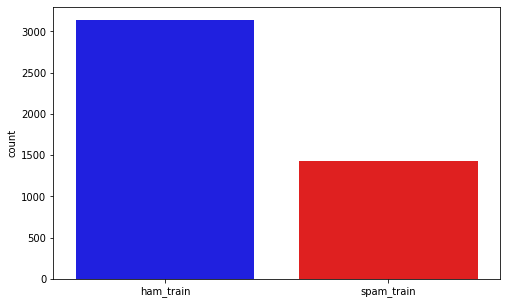

In [158]:
ham = np.array(ham_emails)
spam = np.array(spam_emails)

colors =['blue','red']

plt.figure(figsize=(8, 5))
sns.countplot(x = ['ham_train']*(y_train_2000.shape[0]-np.sum(y_train_2000)) + ['spam_train']*np.sum(y_train_2000) , palette=colors)
plt.show

In [159]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_smote, y_smote = smt.fit_resample(X_train_2000, y_train_2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


<function matplotlib.pyplot.show>

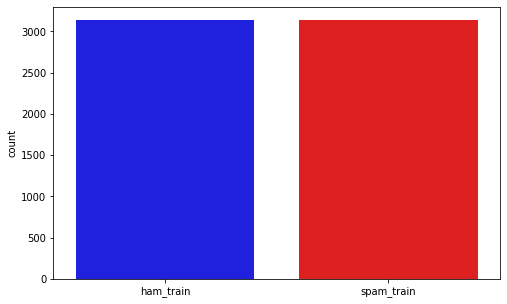

In [160]:
ham = np.array(ham_emails)
spam = np.array(spam_emails)

colors =['blue','red']

plt.figure(figsize=(8, 5))
sns.countplot(x = ['ham_train']*(y_smote.shape[0]-np.sum(y_smote)) + ['spam_train']*np.sum(y_smote) , palette=colors)
plt.show

In [161]:
ypredgaussSmote=Gaussian(X_smote, y_smote, X_test_2000, y_test_2000)
ypredSvmSmote=SVM(X_smote, y_smote, X_test_2000, y_test_2000)
ypredBayesSmote=Bayes(X_smote, y_smote, X_test_2000, y_test_2000)
ypredLog_RegSmote=Log_Reg(X_smote, y_smote, X_test_2000, y_test_2000)
ypredDecision_TreeSmote=Decision_Tree(X_smote, y_smote, X_test_2000, y_test_2000)
ypredMultilayer_neural_networkSmote=Multilayer_neural_network(X_smote, y_smote, X_test_2000, y_test_2000)

Le classifieurs :  Gaussian
Accuracy: 0.8524590163934426
Precision: 0.6996644295302014
Recall: 0.9006479481641468
F1-score:  0.7875354107648725
[[883 179]
 [ 46 417]]
Le classifieurs :  SVM
Accuracy: 0.9678688524590164
Precision: 0.9620535714285714
Recall: 0.9308855291576674
F1-score:  0.9462129527991219
[[1045   17]
 [  32  431]]
Le classifieurs :  Multinomnial Naive Bayes
Accuracy: 0.9718032786885246
Precision: 0.9625550660792952
Recall: 0.9438444924406048
F1-score:  0.9531079607415485
[[1045   17]
 [  26  437]]
Le classifieurs :  Logistic Regression
Accuracy: 0.9763934426229508
Precision: 0.9532908704883227
Recall: 0.9697624190064795
F1-score:  0.961456102783726
[[1040   22]
 [  14  449]]
Le classifieurs :  Decision Tree
Accuracy: 0.9350819672131148
Precision: 0.8807531380753139
Recall: 0.9092872570194385
F1-score:  0.8947927736450584
[[1005   57]
 [  42  421]]
Le classifieurs :  Neural Network
Accuracy: 0.9790163934426229
Precision: 0.961456102783726
Recall: 0.9697624190064795
F1-s

# **Comparing**

## **Machine learning VS deep learning**

ROC CURVE

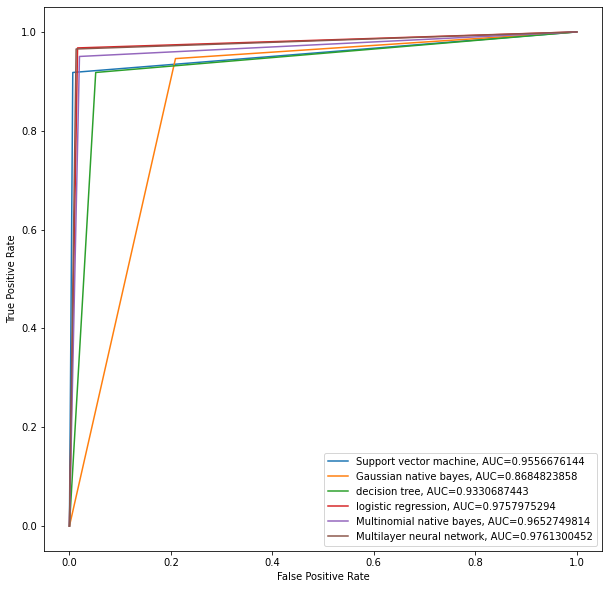

In [162]:

fpr, tpr, _ = metrics.roc_curve(y_test_2000, ypred_svm)
auc = round(metrics.roc_auc_score(y_test_2000, ypred_svm), 10)
plt.plot(fpr,tpr,label="Support vector machine, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_2000, y_pred_gauss)
auc = round(metrics.roc_auc_score(y_test_2000, y_pred_gauss), 10)
plt.plot(fpr,tpr,label="Gaussian native bayes, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_2000,  y_pred_dt)
auc = round(metrics.roc_auc_score(y_test_2000,  y_pred_dt), 10)
plt.plot(fpr,tpr,label="decision tree, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_2000, y_pred_lr)
auc = round(metrics.roc_auc_score(y_test_2000, y_pred_lr), 10)
plt.plot(fpr,tpr,label="logistic regression, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_2000,y_pred_MNB)
auc = round(metrics.roc_auc_score(y_test_2000, y_pred_MNB), 10)
plt.plot(fpr,tpr,label="Multinomial native bayes, AUC="+str(auc))


fpr, tpr, _ = metrics.roc_curve(y_test_2000,y_pred_nn)
auc = round(metrics.roc_auc_score(y_test_2000, y_pred_nn), 10)
plt.plot(fpr,tpr,label="Multilayer neural network, AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)

# **Smote Machine learning Vs Deep learning**

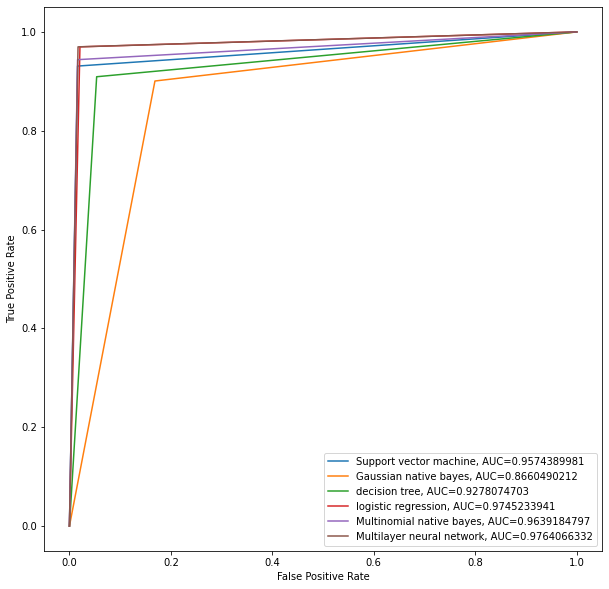

In [163]:

fpr, tpr, _ = metrics.roc_curve(y_test_2000, ypredSvmSmote)
auc = round(metrics.roc_auc_score(y_test_2000, ypredSvmSmote), 10)
plt.plot(fpr,tpr,label="Support vector machine, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_2000, ypredgaussSmote)
auc = round(metrics.roc_auc_score(y_test_2000, ypredgaussSmote), 10)
plt.plot(fpr,tpr,label="Gaussian native bayes, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_2000, ypredDecision_TreeSmote)
auc = round(metrics.roc_auc_score(y_test_2000, ypredDecision_TreeSmote), 10)
plt.plot(fpr,tpr,label="decision tree, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_2000, ypredLog_RegSmote)
auc = round(metrics.roc_auc_score(y_test_2000, ypredLog_RegSmote), 10)
plt.plot(fpr,tpr,label="logistic regression, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_2000,ypredBayesSmote)
auc = round(metrics.roc_auc_score(y_test_2000, ypredBayesSmote), 10)
plt.plot(fpr,tpr,label="Multinomial native bayes, AUC="+str(auc))


fpr, tpr, _ = metrics.roc_curve(y_test_2000,ypredMultilayer_neural_networkSmote)
auc = round(metrics.roc_auc_score(y_test_2000, ypredMultilayer_neural_networkSmote), 10)
plt.plot(fpr,tpr,label="Multilayer neural network, AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)